In [1]:
import cv2
import string
import numpy as np
import os
from keras import layers
from keras.models import Model
from matplotlib import pyplot as plt

2022-07-14 14:44:46.429023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-14 14:44:46.429047: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Reconhecedor CAPTCHA

CAPTCHA significa “Completely Automated Public Turing test to tell Computers and Humans Apart” (Teste de Turing Público Completamente Automatizado para diferenciar computadores e humanos) e como o nome sugere é um modo de evitar que computadores façam ações por si mesmos que orignalmente requerem o manuseio por humanos, como um sistema de votos online por exemplo. Porém, utilizando o conceito de deep learning e visão computacional, o CAPTCHA pode ser "derrotado". Tal objetivo pode ser atingido com a ajuda de Convolutional Neural Networks(CNN). Uma CNN é um algoritmo de deep learning que recebe uma imagem como entrada e, em seguida, atribui algum valor a várias *features* da imagem. Seu principal objetivo é transformar as imagens em um formato muito mais fácil de processar, sem perder *features* essenciais para obter uma previsão otimizada.

### Instruções para instalação das bibliotecas
Para executar o notebook, são necessários o OpenCV, Tensorflow e Keras. Podem ser instalados com os comandos:

```bash
$ pip install opencv-python
$ pip install tensorflow
$ pip install keras
```

### Descrição do Dataset

O conjunto de dados usado para este projeto consiste em 10000 imagens .jpg de CAPTCHA baseado em texto. Cada imagem do conjunto de dados tem um conjunto de 6 caracteres e o conjunto de caracteres é definido como todas as letras maiúsculas e dígitos de 0 a 9. Portanto, um total de 36 caracteres está presente no conjunto de caracteres.
O conjunto de dados é separado em treinamento (utilizado para treinar o modelo), com 8000 imagens, validação com 1000 imagens e teste com 1000 imagens. O aprendizado é feito apenas com a utilização das imagens contidas no diretório treinamento e a validação de parâmetros é feita apenas com imagens do diretório validação. As imagens do diretório teste são utilizadas para avaliação do método.

### Etapas

1. Pré processamento dos dados
    * Leitura das imagens
    * Leitura dos labels
    * Configuração do array de labels
2. Criação do modelo
3. Processo de fit e treinamento do modelo com os dados de treinamento e validação
4. Execução dos modelo com os dados de teste
5. Análise dos resultados


### Pré processamento dos dados
Primeiramente são definidas algumas constantes que serão utilizadas ao longo do projeto, como o shape das imagens de entrada e o número de caracteres por CAPTCHA.

In [2]:
IMG_WIDTH = 180
IMG_HEIGHT = 50
NUM_TRAINING_IMGS = 8000
NUM_TEST_IMGS = 1000

NUM_CHARS_IN_CAPTCHA = 6

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1) # 1 is the number of channels

CHARACTERS = string.ascii_uppercase + "0123456789"
N_CHARS = len(CHARACTERS)
N_CHARS

36

A função `get_labels()` é responsável por ler todas as labels de todos os arquivos de labels dentro da pasta `dados/CAPTCHA-10k/labels10k` e então ordená-las em ordem crescente. A função `get_X_and_y` é a que vai transformar as imagens e os labels nas estruturas que serão passadas como parâmetros para a rede convolucional. O X é simplesmente um array de imagens, que possuem um único canal e tem seus valores normalizados. O y é um pouco mais "tricky". Para cada imagem são armazenados 6 arrays, um para cada letra do captcha. Em cada array, sempre há 36 posições, uma para cada caractere possível (A-Z 0-9). Todas as posições são preenchidas com zero, menos àquela referente ao caractere `i` do label da imagem. Segue um exemplo para melhor entendimento.

```python

# exemplo da estrutura y da imagem com label "ABCDDE"
# "..." significam +28 zeros (8 posições + 28 = 36)

[
    [1,0,0,0,0,0,0,0 ...],
    [0,1,0,0,0,0,0,0 ...],
    [0,0,1,0,0,0,0,0 ...],
    [0,0,1,0,0,0,0,0 ...],
    [0,0,0,1,0,0,0,0 ...],
    [0,0,0,0,1,0,0,0 ...],
]


```
Cada imagem possui um correspondente y como o descrito acima.

NZKAGQ
(6, 36)


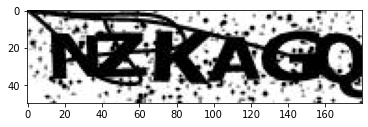

In [3]:
def get_labels():
    labels = []
    sorted = os.listdir("dados/CAPTCHA-10k/labels10k")
    sorted.sort()
    
    for i in sorted:
        captcha = open("dados/CAPTCHA-10k/labels10k/" + i, 'r').read().strip()
        labels.append(captcha)

    return labels

def get_X_and_y(type, labels):
    n = NUM_TRAINING_IMGS
    shift = 0

    if type == "validacao":
        n = NUM_TEST_IMGS
        shift = 8000

    if type == "teste":
        n = NUM_TEST_IMGS
        shift = 9000
    

    X = np.zeros((n, IMG_HEIGHT, IMG_WIDTH, 1))
    y = np.zeros((NUM_CHARS_IN_CAPTCHA, n, N_CHARS))

    files = os.listdir("dados/CAPTCHA-10k/" + type)
    files.sort()

    for i, pic in enumerate(files):
        img = cv2.imread(os.path.join("dados/CAPTCHA-10k/" + type, pic), cv2.IMREAD_GRAYSCALE)
        pic_target = labels[i + shift]

        if len(pic_target) < 7:
            img = img / 255.0 # scales the image between 0 and 1
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1)) 

            target=np.zeros((NUM_CHARS_IN_CAPTCHA, N_CHARS))

            for j, k in enumerate(pic_target):
                index = CHARACTERS.find(k) # index stores the position of letter k of captcha in the character string
                target[j, index] = 1 # replaces 0 with 1 in the target array at the position of the letter in captcha

            X[i] = img
            y[:,i] = target

    return X, y

labels = get_labels()
X_training, y_training = get_X_and_y(type="treinamento", labels=labels)

plt.imshow(X_training[700], cmap=plt.get_cmap("gray"))
print(labels[0 + 700])
print(y_training[:,0].shape)

## Criação do modelo
O modelo criado é uma rede convolucional que converge para 6 saídas diferentes, uma para cada caractere do CAPTCHA. O número de camadas e os valores definidos foram escolhidos de forma experimental e também baseado em pesquisas, de forma a buscar a simplicidade do modelo. O modelo consiste em kernels de tamanho 3x3, 4 camadas de convolução e 4 camadas de MaxPooling. Os detalhes mais específicos do modelo podem ser vistos abaixo, com a chamada da função `model.summary()` presente na classe model do Keras.

In [4]:
def createModel():
    img = layers.Input(shape=IMG_SHAPE) # Get image as an input of size IMG_SHAPE
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img) #50*180
    
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 25*90
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 13*45
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    
    mp3 = layers.MaxPooling2D(padding='same')(conv3)  # 13*45
    conv4 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp3)

    bn = layers.BatchNormalization()(conv4) # to improve the stability of model
    mp4 = layers.MaxPooling2D(padding='same')(bn)  # 7*23
    
    flat = layers.Flatten()(mp4) #convert the layer into 1-D

    outs = []
    for _ in range(NUM_CHARS_IN_CAPTCHA): # 6 letters of captcha
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        res = layers.Dense(N_CHARS, activation='sigmoid')(drop)

        outs.append(res)
    
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [5]:
model = createModel()
model.summary()

2022-07-14 14:44:50.740872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-14 14:44:50.740912: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-14 14:44:50.740938: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luizcouto-X510URR): /proc/driver/nvidia/version does not exist
2022-07-14 14:44:50.741186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 180, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 180, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 90, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 90, 32)   4640        ['max_pooling2d[0][0]']      

### Processo de fit e treinamento do modelo com os dados de treinamento e validação
Nessa etapa, utilizamos a função `model.fit()` presente no Keras para treinar o modelo. Passamos como parãmetro o array de imagens X e a estrutura y como explicado na etapa anterior. Perceba que para cada imagem X, temos 6 posições consecutivas de Y, uma para cada caractere de X[i]. É por esse motivo que a chamada da função tem como parâmetro `(X_training, [y_training[0], y_training[1], y_training[2], y_training[3], y_training[4], y_training[5]])`. Para o treinamento, foram realizados 25 epochs/iterações (valor calculado de forma experimental).

In [6]:
X_validation, y_validation = get_X_and_y(type="validacao", labels=labels)

hist = model.fit(X_training, [y_training[0], y_training[1], y_training[2], y_training[3], y_training[4], y_training[5]], 
                batch_size=32, epochs=25, 
                validation_data=(X_validation, [y_validation[0], y_validation[1], y_validation[2], y_validation[3], y_validation[4], y_validation[5]]))

Epoch 1/25


2022-07-14 14:44:51.732304: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 288000000 exceeds 10% of free system memory.


250/250 [==============================] - 26s 94ms/step - loss: 21.5266 - dense_1_loss: 3.5879 - dense_3_loss: 3.5876 - dense_5_loss: 3.5896 - dense_7_loss: 3.5876 - dense_9_loss: 3.5895 - dense_11_loss: 3.5843 - dense_1_accuracy: 0.0318 - dense_3_accuracy: 0.0281 - dense_5_accuracy: 0.0292 - dense_7_accuracy: 0.0289 - dense_9_accuracy: 0.0346 - dense_11_accuracy: 0.0306 - val_loss: 21.4759 - val_dense_1_loss: 3.5783 - val_dense_3_loss: 3.5803 - val_dense_5_loss: 3.5789 - val_dense_7_loss: 3.5804 - val_dense_9_loss: 3.5802 - val_dense_11_loss: 3.5778 - val_dense_1_accuracy: 0.0380 - val_dense_3_accuracy: 0.0230 - val_dense_5_accuracy: 0.0370 - val_dense_7_accuracy: 0.0290 - val_dense_9_accuracy: 0.0320 - val_dense_11_accuracy: 0.0330
Epoch 2/25
250/250 [==============================] - 23s 94ms/step - loss: 19.1666 - dense_1_loss: 3.0898 - dense_3_loss: 3.2710 - dense_5_loss: 3.1888 - dense_7_loss: 3.3025 - dense_9_loss: 3.2878 - dense_11_loss: 3.0267 - dense_1_accuracy: 0.1334 - den

Abaixo é mostrado o gráfico de perda (loss) de acordo com o número de epochs.

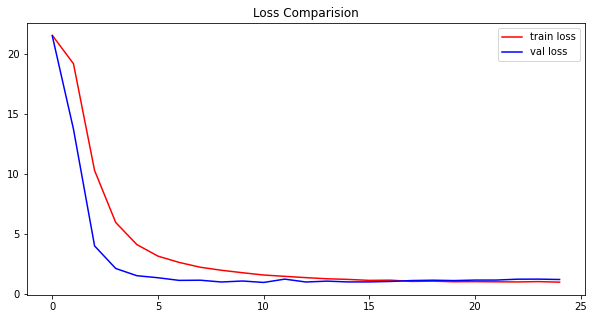

In [7]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5))
axis.plot(hist.history["loss"], color='r', label = 'train loss')
axis.plot(hist.history["val_loss"], color='b', label = 'val loss')
axis.set_title('Loss Comparision')
axis.legend()

E abaixo é mostrado a acurácia da camada Dense_1, também de acordo com o número de epochs.

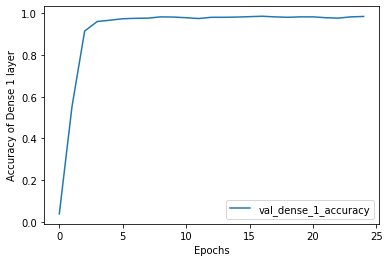

In [8]:

#graph of accuracy of dense_2 vs epochs
for label in ["val_dense_1_accuracy"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy of Dense 1 layer")
plt.show()



### Execução dos modelo com os dados de teste
Para executar o modelo com as imagens do diretório de teste, foi criada a função `predict` que recebe como entrada o caminho para um arquivo de teste e retorna o CAPTCHA de acordo com o modelo. Primeiramente, é preciso aumentar o número de dimensões da imagem de forma a adaptar à estrutura do modelo. Então, utiliza-se a função `model.predict()` do Keras para predizer quais os caracteres presentes na imagem. O retorno de `model.predict` é um array igual ao da estrutura y, mas que contém valores entre 0 e 1 para cada array de cada caractere do CAPTCHA. Cada valor significa o quão próximo o caractere em questão está do elemento i do array de caracteres (A-Z 0-9). Por exemplo, caso executássemos o teste em uma imagem e obtivéssemos a saída abaixo, o modelo abaixo estaria prevendo que o o CAPTCHA em questão possui a label "ABCDDE". O restante da função apenas transforma essa estrutura na label em si.

```python
# Considere o restante das 36 posiçoes de cada array como zeros

y = 
[
    [0.98, 0.5, 0.7, 0, 0, 0, 0, 0 ...],
    [0.2, 0.99, 0.6, 0, 0, 0, 0, 0 ...],
    [0.1, 0.2, 0.9, 0, 0, 0, 0, 0 ...],
    [0.3, 0.1, 0.1, 0.98, 0, 0, 0, 0 ...],
    [0.3, 0.1, 0.1, 0.98, 0, 0, 0, 0 ...],
    [0.1, 0.1, 0.1, 0.2, 0.2, 0.95, 0, 0 ...],
]

```


JW4CZF
1/1 [==============================] - 0s 161ms/step


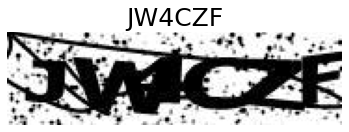

In [9]:
def predict(filepath, model):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        img = img / 255.0
    else:
        print("Image not found");

    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    result = np.reshape(res, (NUM_CHARS_IN_CAPTCHA, N_CHARS))
    k_ind = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = ""
    for k in k_ind:
        capt += CHARACTERS[k] #finds the char corresponding to the index
    return capt

def show_prediction(img, predicted):
    img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    plt.title(predicted, fontsize=25)
    plt.imshow(img, cmap=plt.get_cmap("gray"))
    plt.axis("off")

print(labels[9000])
predicted = predict("dados/CAPTCHA-10k/teste/009001.jpg", model)
show_prediction("dados/CAPTCHA-10k/teste/009001.jpg", predicted)

A função abaixo `show_test_sample` executa para os primeiros 12 CAPTCHAs da pasta de teste a função predict mostrada acima. Os resultados estão abaixo. A label predita está acima de cada imagem de CAPTCHA

1/1 [==============================] - 0s 16ms/step


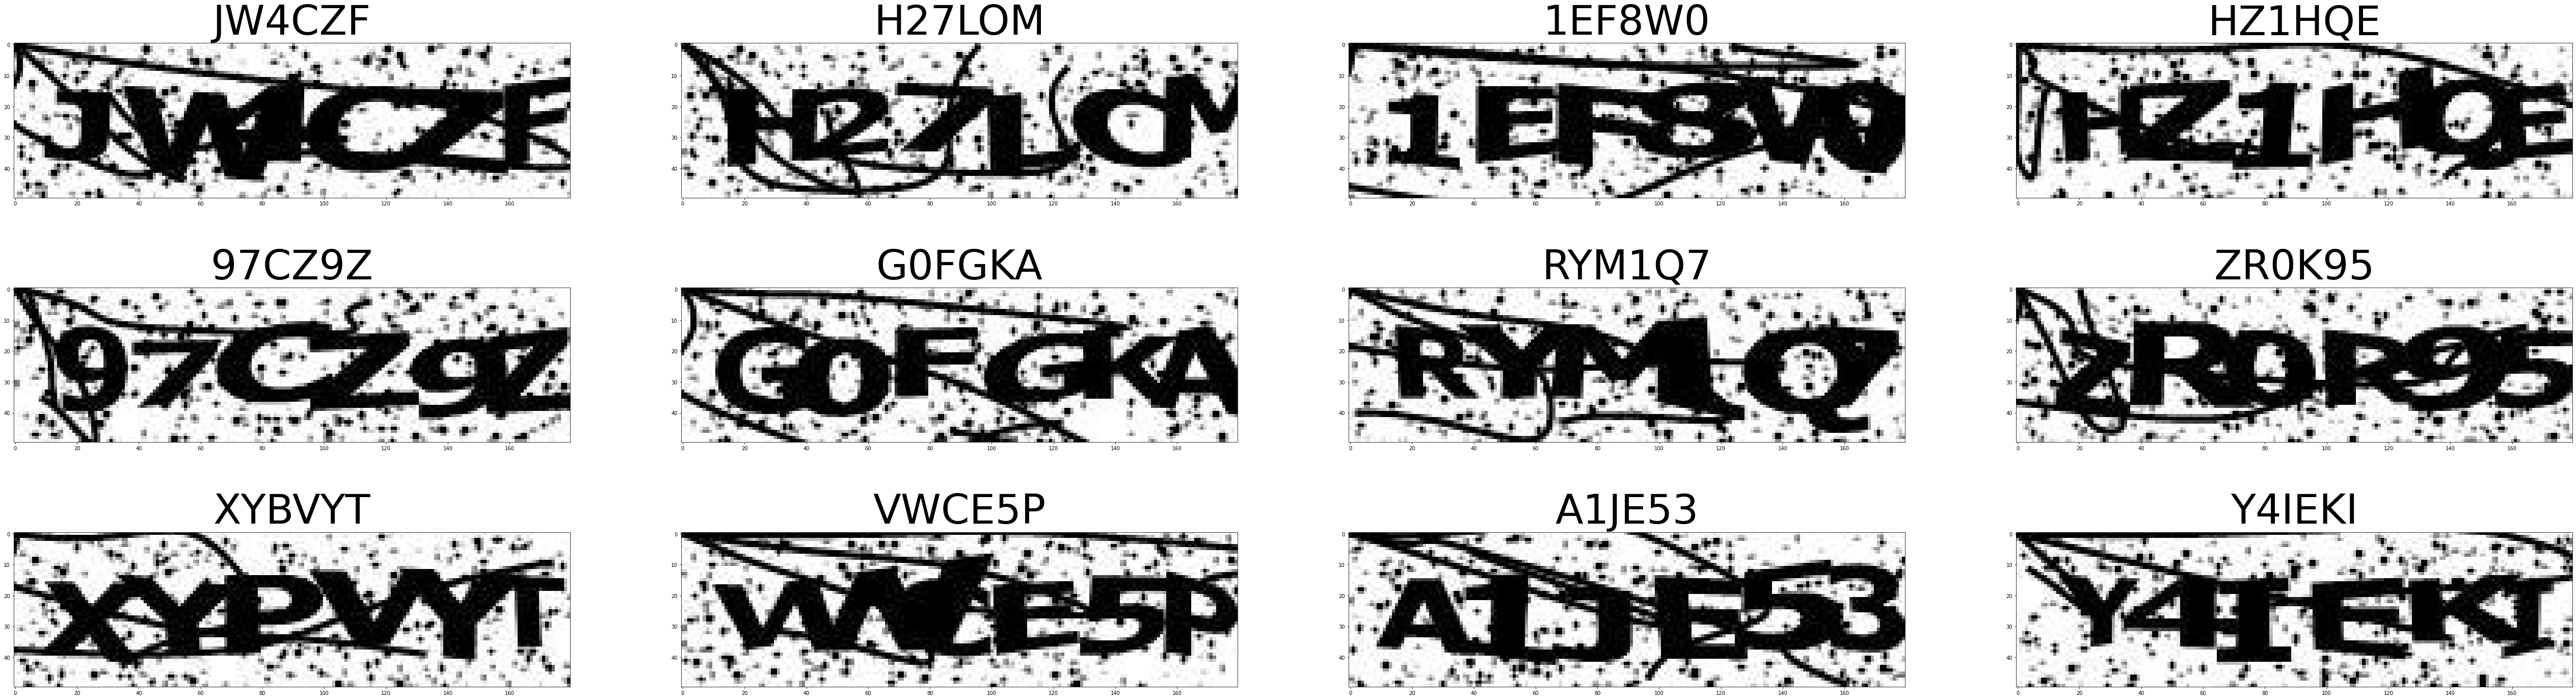

In [10]:
def show_test_sample(model):
    files = os.listdir("dados/CAPTCHA-10k/teste")
    files.sort()

    fig = plt.figure(figsize=(IMG_WIDTH/2,IMG_HEIGHT/2))
    columns = 4
    rows = 3
    for i in range(1,columns*rows + 1):
        path = os.path.join("dados/CAPTCHA-10k/teste", files[i-1])
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        predicted = predict(path, model)
        
        x = fig.add_subplot(rows, columns, i)
        x.set_title(predicted, fontsize = 80)
        plt.imshow(img, cmap=plt.get_cmap("gray"))
    
    plt.show()


show_test_sample(model)

Já a função abaixo roda a função predict para todos os 1000 casos da pasta de teste, e armazena os resultados e os labels esperados (para posterior análise).

In [11]:
def run_test(model, labels):
    files = os.listdir("dados/CAPTCHA-10k/teste")
    files.sort()
    shift = 9000

    predictions = []
    targets = []

    for i, pic in enumerate(files):
        path = os.path.join("dados/CAPTCHA-10k/teste", pic)
        
        predicted = predict(path, model)
        predictions.append(predicted)
        
        target = labels[shift + i]
        targets.append(target)

    return predictions, targets

In [12]:
predictions, targets = run_test(model, labels)

1/1 [==============================] - 0s 17ms/step


### Análise dos resultados
Após a execução dos testes, foi observado que em 69.3% das vezes o CAPTCHA foi corretamente previsto por inteiro (todos os 6 carcteres). Considerando a totalidade dos caracteres, o modelo conseguiu predizer corretamente 93.86% caracteres. O gráfico de número de caracteres reconhecidos por CAPCTHA pela taxa de reconhecimento é mostrado abaixo.

In [13]:
def diff_letters(a,b):
    return sum ( a[i] != b[i] for i in range(len(a)) )

equals = 0
total_diff = 0
recognition = []
for i in range(len(predictions)):
    diff = diff_letters(predictions[i], targets[i])
    if diff == 0:
        equals += 1

    total_diff += diff
    recognition.append(NUM_CHARS_IN_CAPTCHA - diff)

print("Porcentagem de CAPTCHAS completamente reconhecidos (todos os 6 caracteres):", equals/NUM_TEST_IMGS * 100)
print("Porcentagem de caracteres reconhecidos:", (1 - (total_diff/(NUM_TEST_IMGS*6))) * 100)


Porcentagem de CAPTCHAS completamente reconhecidos (todos os 6 caracteres): 69.39999999999999
Porcentagem de caracteres reconhecidos: 94.01666666666667


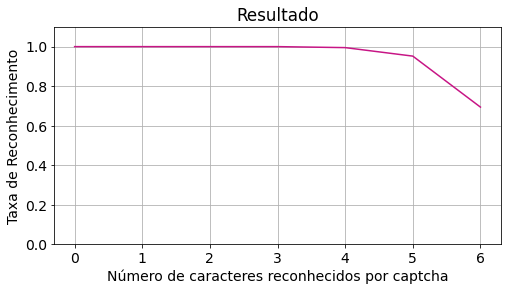

In [14]:
x = [0,1,2,3,4,5,6]
y = []
for k in range(0, NUM_CHARS_IN_CAPTCHA+1):
    y.append(sum(i >= k for i in recognition) / 1000)

plt.rcParams.update({'font.size':14})
plt.rcParams["figure.figsize"] = (8,4)
fig, ax = plt.subplots()
plt.title("Resultado")
ax.set_ylim(bottom=0, top=1.1)
plt.xlabel("Número de caracteres reconhecidos por captcha")
plt.ylabel("Taxa de Reconhecimento")
plt.grid()
plt.plot(x, y, color = 'mediumvioletred')
plt.show()

